In [ ]:
import csv
import math
import copy
import numpy as np
import pandas as pd
import random as rd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection

###Spread function

In [ ]:
def graph_generation(graph_type, number_of_nodes, BA_connect = None, ER_prob = None):
  if graph_type == 'BA':
    G = nx.barabasi_albert_graph(number_of_nodes, BA_connect)
  elif graph_type == 'ER':
    G = nx.erdos_renyi_graph(number_of_nodes, ER_prob)
  else:
    print("Wrong graph_type. Choose BA or ER.")
  print(G.size())

  return G

In [ ]:
number_of_days = 10000
number_of_nodes = 2500
new_grains = []
BA_connect = 1
ER_prob = 0.0016
for d in range(0, number_of_days):
  grain = np.random.randint(number_of_nodes)
  new_grains.append(grain)

In [ ]:
def counter(G, number_of_days):
  inner = []
  outer = []
  i = 0

  final_status = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
  for column in final_status:
    i += 1
    inner.append(np.sum(final_status[column]))
    outer.append(i - np.sum(final_status[column]))

  return inner, outer

In [ ]:
def covid_spread(model, G, number_of_days, new_grains, graph_type, facilitated=False):

  inner = []
  outer = []
  falls = []
  ones = []
  deg = []

  degrees = [[node, val]  for (node, val) in G.degree()]
  for degree in degrees:
    deg.append(degree[1])
    if degree[1] == 1:
      ones.append(degree[0])

  status = pd.DataFrame()
  for j in range(0, number_of_days):
    status['ill'+str(j)] = np.zeros(G.number_of_nodes())

  node_attr = status.to_dict('index')
  nx.set_node_attributes(G, node_attr)

  if facilitated == True:
    facilit_list = [[0 for x in range(G.number_of_nodes())] for z in range(number_of_days)]

  for d in tqdm(range(0, number_of_days-1)):
    falls_d = 0
    for node in G.nodes(data=True):
      if node[0] == new_grains[d]:
        node[1]['ill'+str(d)] += 1.0
      node[1]['ill'+str(d+1)] += node[1]['ill'+str(d)]
    for node in G.nodes(data=True):
      if facilitated == False:
        if d <= (number_of_days-1) and node[1]['ill'+str(d)] >= deg[node[0]] and deg[node[0]] > 0:
          if model == "BTW":
            G, falls_d = BTW(G, ones, falls_d, d, node, deg[node[0]])
          if model == "MA":
            G, falls_d = MA(G, ones, falls_d, d, node, deg[node[0]])
          if model == "FE":
            G, falls_d = FE(G, ones, falls_d, d, node, deg[node[0]])    
          if model == "SFE":
            G, falls_d = SFE(G, ones, falls_d, d, node, deg[node[0]])
      else:
        if d<=(number_of_days-1) and (node[1]['ill'+str(d)] >= deg[node[0]] or facilit_list[d][node[0]] >= 2) and deg[node[0]] > 0:
          if model == "BTW":
            G, facilit_list, falls_d = BTW_fa(G, facilit_list, ones, falls_d, d, node, deg[node[0]])
          if model == "MA":
            G, facilit_list, falls_d = MA_fa(G, facilit_list, ones, falls_d, d, node, deg[node[0]])
          if model == "FE":
            G, facilit_list, falls_d = FE_fa(G, facilit_list, ones, falls_d, d, node, deg[node[0]])    
          if model == "SFE":
            G, facilit_list, falls_d = SFE_fa(G, facilit_list, ones, falls_d, d, node, deg[node[0]])

    if d <= number_of_days-2:
      falls.append(falls_d)
  inner, outer = counter(G, d)
  #final_status = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
  #for d in range(0, number_of_days):
    #print(final_status["ill"+str(d)])
    #print("End of day")
  #for d in range(0, len(matrix)):
    #for i in range(0, len(matrix[0])):
      #for j in range(0, len(matrix[0][0])):
        #matrix[d][i][j] = 0

  print(inner)
  print(outer)
  print(falls)

  if facilitated == False:  
    with open(graph_type + model + '.csv', 'w') as myfile:
      wr = csv.writer(myfile, delimiter=',')
      wr.writerow(falls)

  if facilitated == True:  
    with open(graph_type + model + '_fa.csv', 'w') as myfile:
      wr = csv.writer(myfile, delimiter=',')
      wr.writerow(falls)

  fig, axs = plt.subplots(2, 1, figsize=(15, 10))
  axs[0].xaxis.get_major_locator().set_params(integer=True)
  axs[0].yaxis.get_major_locator().set_params(integer=True)
  axs[1].xaxis.get_major_locator().set_params(integer=True)
  axs[1].yaxis.get_major_locator().set_params(integer=True)
  axs[0].set(ylim=(0, 10000))
  axs[1].set(ylim=(0, 100))
  axs[0].ticklabel_format(style='plain')
  axs[1].ticklabel_format(style='plain')
  axs[0].plot(list(range(number_of_days)), inner, color='#40a6d1', alpha = 0.5, label = "Inner Grains")
  axs[0].plot(list(range(number_of_days)), outer, color='red', alpha = 0.5, label = "Outer Grains")
  axs[0].legend(loc = 'upper right', fontsize='medium')
  axs[0].set_title('Number of grains in and out of the model')
  axs[1].plot(list(range(number_of_days-1)), falls, color='#40a6d1', alpha = 0.5)
  axs[1].set_title('Number of falls in the model')
  plt.setp(axs[0], xlabel='Day', ylabel='Grains')
  plt.setp(axs[1], xlabel='Day', ylabel='Falls')
  plt.tight_layout()
  plt.show()

### Model definition

In [ ]:
def BTW(G, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    for neighbor in G.nodes(data=True):
      if neighbor[0] in neighbors:
        neighbor[1]['ill'+str(d+1)] += 1
  node[1]['ill'+str(d+1)] -= crit

  return G, falls_d

In [ ]:
def BTW_fa(G, facilit_list, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    if node[1]['ill'+str(d)] >= crit:
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          neighbor[1]['ill'+str(d+1)] += 1
          facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= crit
    else:
      remains = node[1]['ill'+str(d)]
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0:
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
  else:
    node[1]['ill'+str(d+1)] -= crit

  return G, facilit_list, falls_d

In [ ]:
def MA(G, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    remains = copy.copy(crit)
    for neighbor in G.nodes(data=True):
      if neighbor[0] in neighbors:
        n = rd.randint(0, remains)
        remains -= n
        neighbor[1]['ill'+str(d+1)] += n
  node[1]['ill'+str(d+1)] -= crit

  return G, falls_d

In [ ]:
def MA_fa(G, facilit_list, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    if node[1]['ill'+str(d)] >= crit:
      remains = copy.copy(crit)
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= crit
    else:
      remains = node[1]['ill'+str(d)]
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
  else:
    node[1]['ill'+str(d+1)] -= crit

  return G, facilit_list, falls_d

In [ ]:
def FE(G, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    for neighbor in G.nodes(data=True):
      if neighbor[0] in neighbors:
        neighbor[1]['ill'+str(d+1)] += 1
  node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]

  return G, falls_d

In [ ]:
def FE_fa(G, facilit_list, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    if node[1]['ill'+str(d)] >= crit:
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          neighbor[1]['ill'+str(d+1)] += 1
          facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
    else:
      remains = node[1]['ill'+str(d)]
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
  else:
    node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]

  return G, facilit_list, falls_d

In [ ]:
def SFE(G, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    remains = copy.copy(crit)
    for neighbor in G.nodes(data=True):
      if neighbor[0] in neighbors:
        n = rd.randint(0, remains)
        remains -= n
        neighbor[1]['ill'+str(d+1)] += n
  node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]

  return G, falls_d

In [ ]:
def SFE_fa(G, facilit_list, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    if node[1]['ill'+str(d)] >= crit:
      remains = copy.copy(crit)
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
    else:
      remains = node[1]['ill'+str(d)]
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
  else:
    node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]

  return G, facilit_list, falls_d

### Bak-Tang-Wiesenfeld

#### Standart Model

In [ ]:
G_BA = graph_generation(graph_type = "BA", number_of_nodes = number_of_nodes, BA_connect = BA_connect)

2499


100%|██████████| 9999/9999 [01:48<00:00, 92.57it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 37.0, 38.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 45.0, 45.0, 46.0, 46.0, 47.0, 47.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 53.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 55.0, 55.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 58.0, 58.0, 58.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 69.0, 69.0, 70.0, 70.0, 70.0, 70.0, 

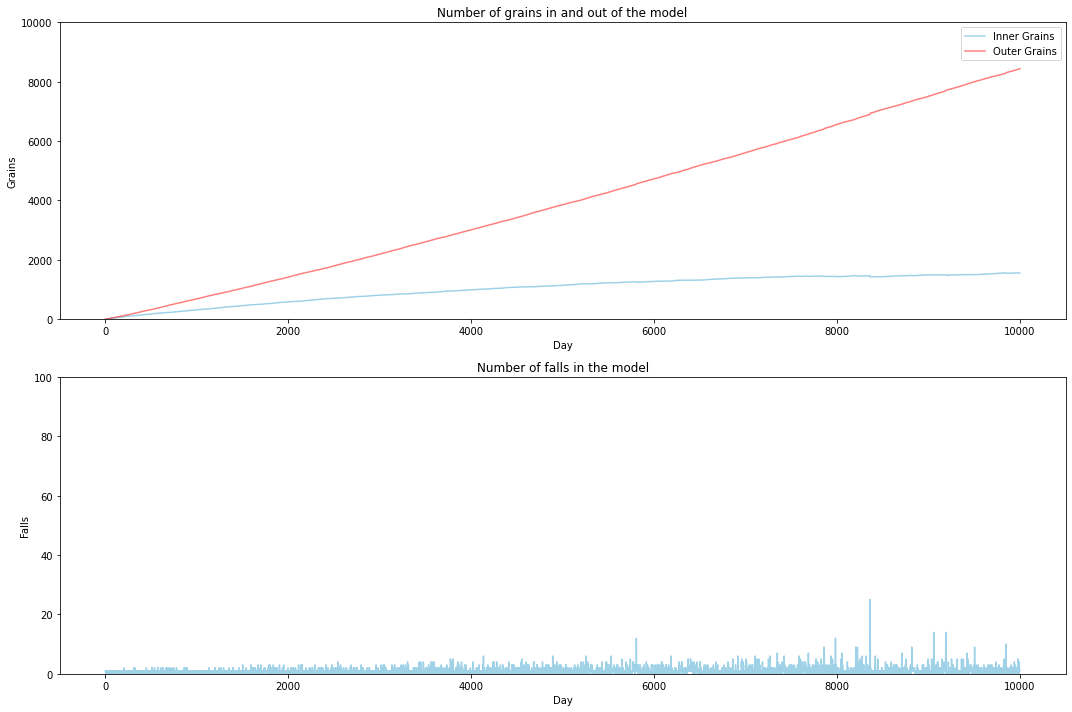

In [ ]:
covid_spread("BTW", G_BA, number_of_days, new_grains, "BA")

In [ ]:
G_ER = graph_generation(graph_type = "ER", number_of_nodes = number_of_nodes, ER_prob = ER_prob)

5032


100%|██████████| 9999/9999 [02:17<00:00, 72.86it/s]


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 97.0, 98.0, 98.0, 99.0, 100.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 132.0, 133.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 14

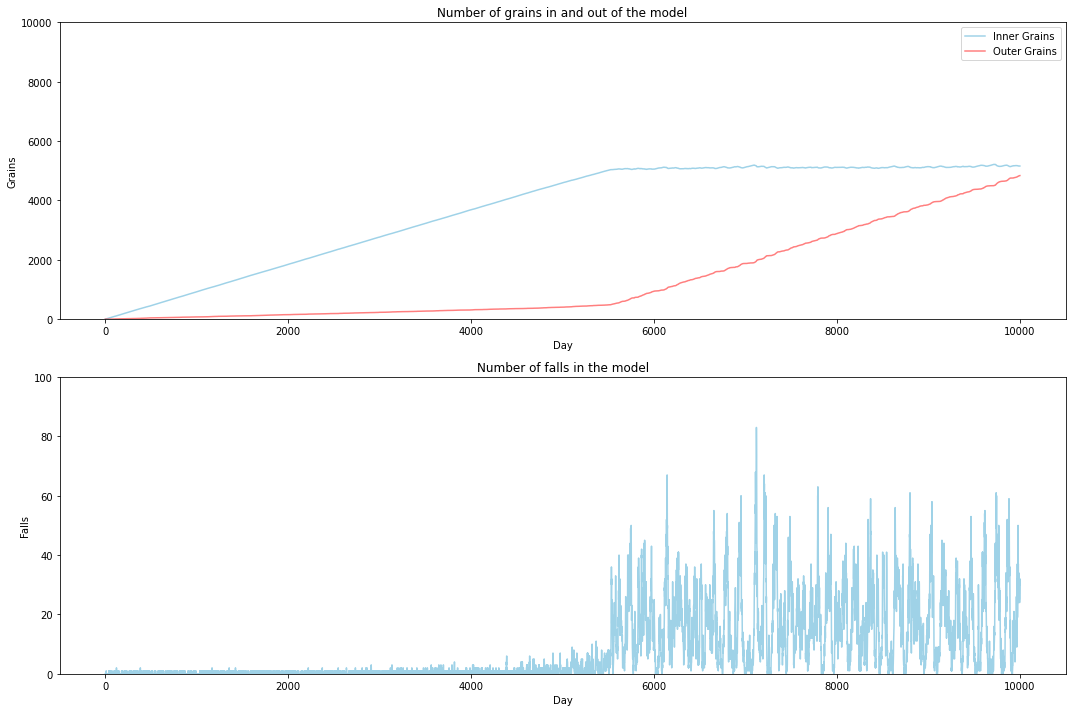

In [ ]:
covid_spread("BTW", G_ER, number_of_days, new_grains, "ER")

#### Facilitated Model

100%|██████████| 9999/9999 [01:55<00:00, 86.76it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 37.0, 38.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 45.0, 45.0, 46.0, 46.0, 47.0, 47.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 53.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 55.0, 55.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 58.0, 58.0, 58.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 69.0, 69.0, 70.0, 70.0, 70.0, 70.0, 

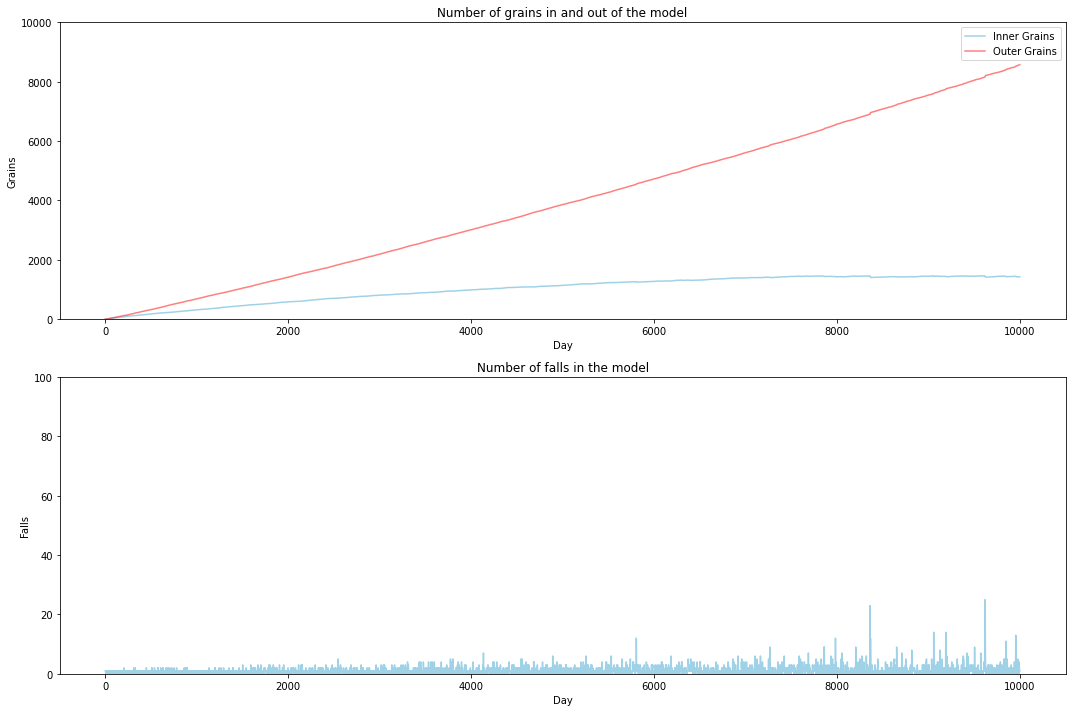

In [ ]:
covid_spread("BTW", G_BA, number_of_days, new_grains, "BA", facilitated = True)

100%|██████████| 9999/9999 [02:19<00:00, 71.72it/s]


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 97.0, 98.0, 98.0, 99.0, 100.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 132.0, 133.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 14

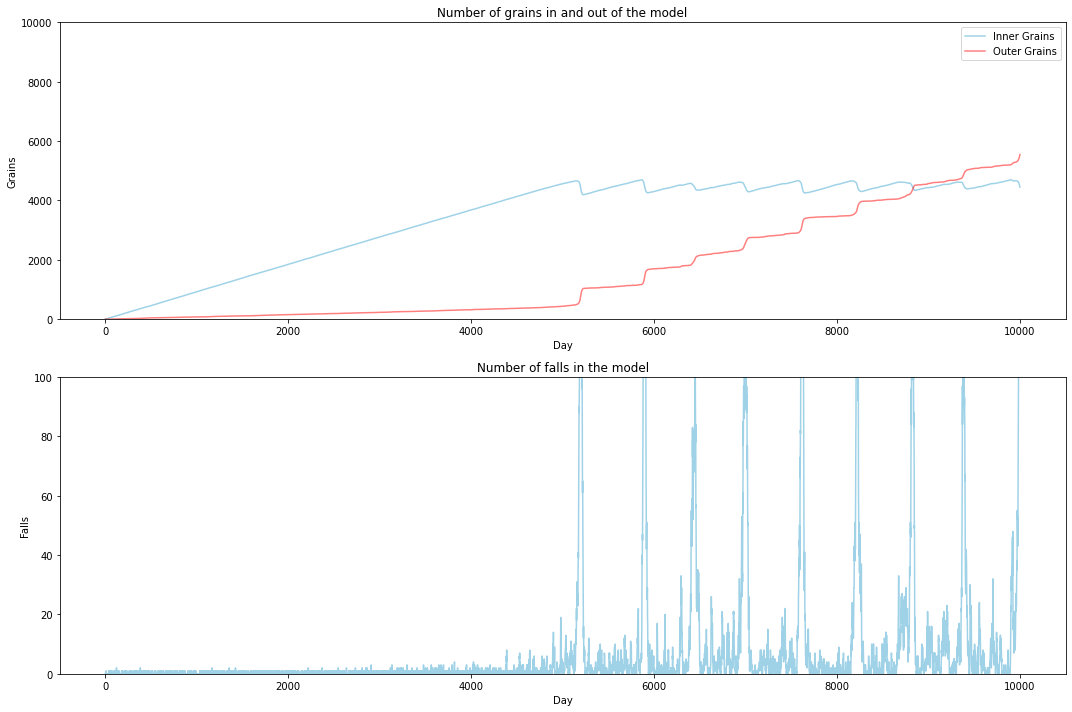

In [ ]:
covid_spread("BTW", G_ER, number_of_days, new_grains, "ER", facilitated = True)

### Mann

#### Standart Model

100%|██████████| 9999/9999 [01:51<00:00, 89.34it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 37.0, 38.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 45.0, 45.0, 46.0, 46.0, 47.0, 47.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 53.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 55.0, 55.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 58.0, 58.0, 58.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 69.0, 69.0, 70.0, 70.0, 70.0, 70.0, 

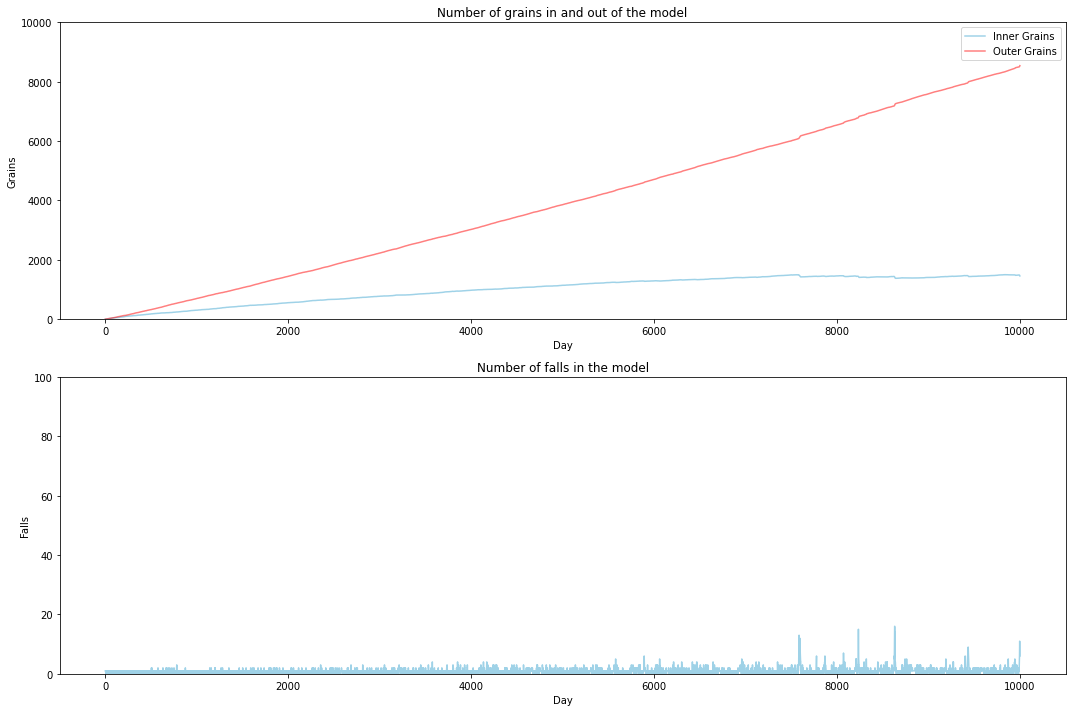

In [ ]:
covid_spread("MA", G_BA, number_of_days, new_grains, "BA")

100%|██████████| 9999/9999 [02:01<00:00, 82.62it/s]


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 97.0, 98.0, 98.0, 99.0, 100.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 132.0, 133.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 14

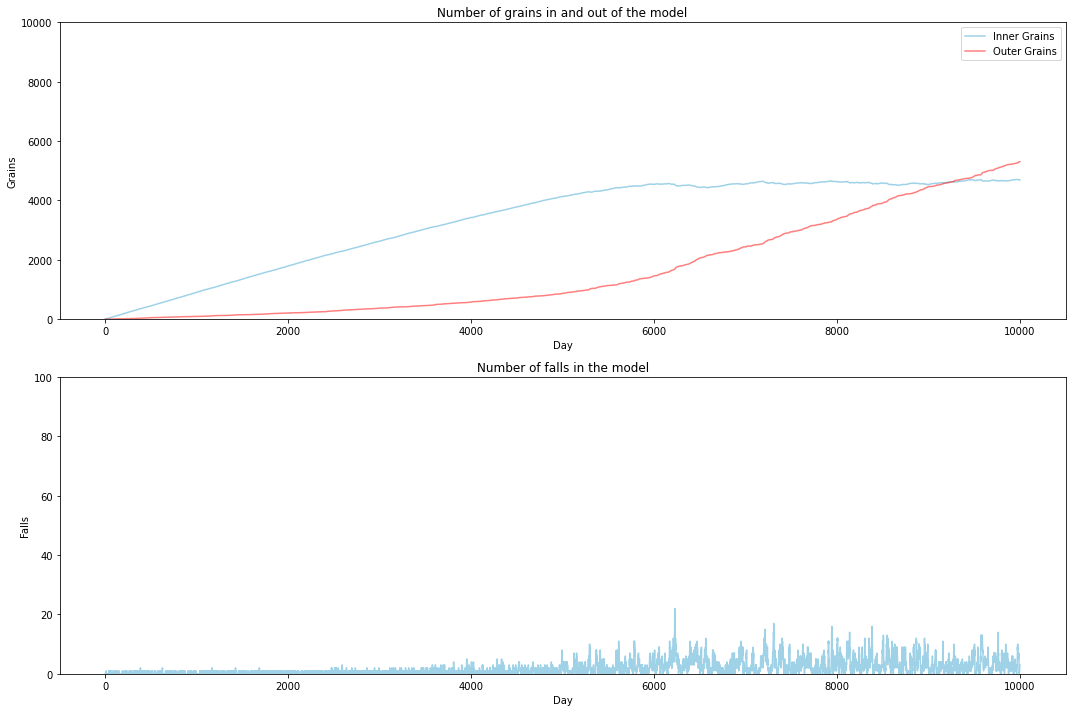

In [ ]:
covid_spread("MA", G_ER, number_of_days, new_grains, "ER")

#### Facilitated Model

100%|██████████| 9999/9999 [01:53<00:00, 87.90it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 37.0, 38.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 45.0, 45.0, 46.0, 46.0, 47.0, 47.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 53.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 55.0, 55.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 58.0, 58.0, 58.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 69.0, 69.0, 70.0, 70.0, 70.0, 70.0, 

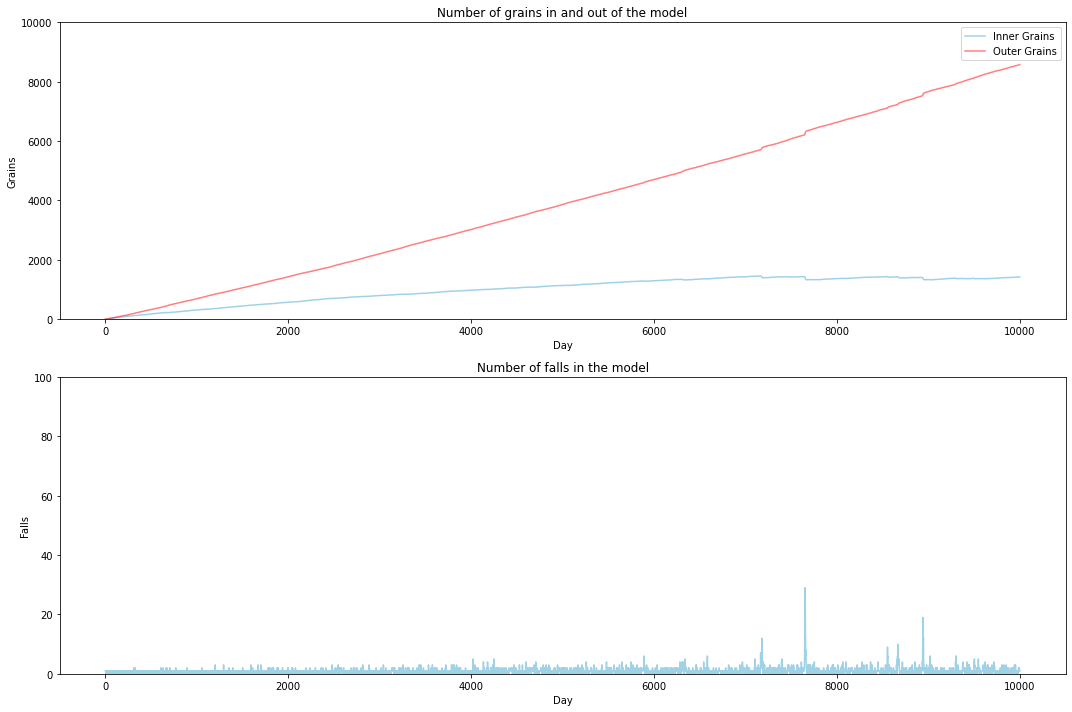

In [ ]:
covid_spread("MA", G_BA, number_of_days, new_grains, "BA", facilitated = True)

100%|██████████| 9999/9999 [01:56<00:00, 86.13it/s]


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 97.0, 98.0, 98.0, 99.0, 100.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 131.0, 132.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 14

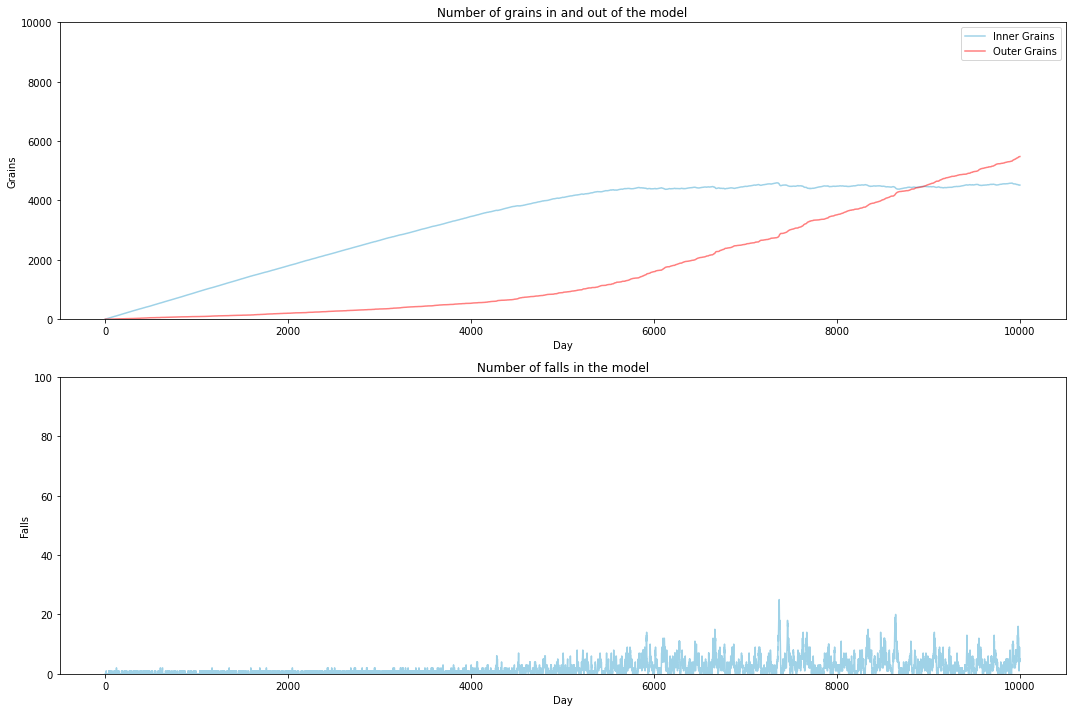

In [ ]:
covid_spread("MA", G_ER, number_of_days, new_grains, "ER", facilitated = True)

### Feder

#### Standart Model

100%|██████████| 9999/9999 [01:54<00:00, 87.03it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 37.0, 38.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 45.0, 45.0, 46.0, 46.0, 47.0, 47.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 53.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 55.0, 55.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 58.0, 58.0, 58.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 69.0, 69.0, 70.0, 70.0, 70.0, 70.0, 

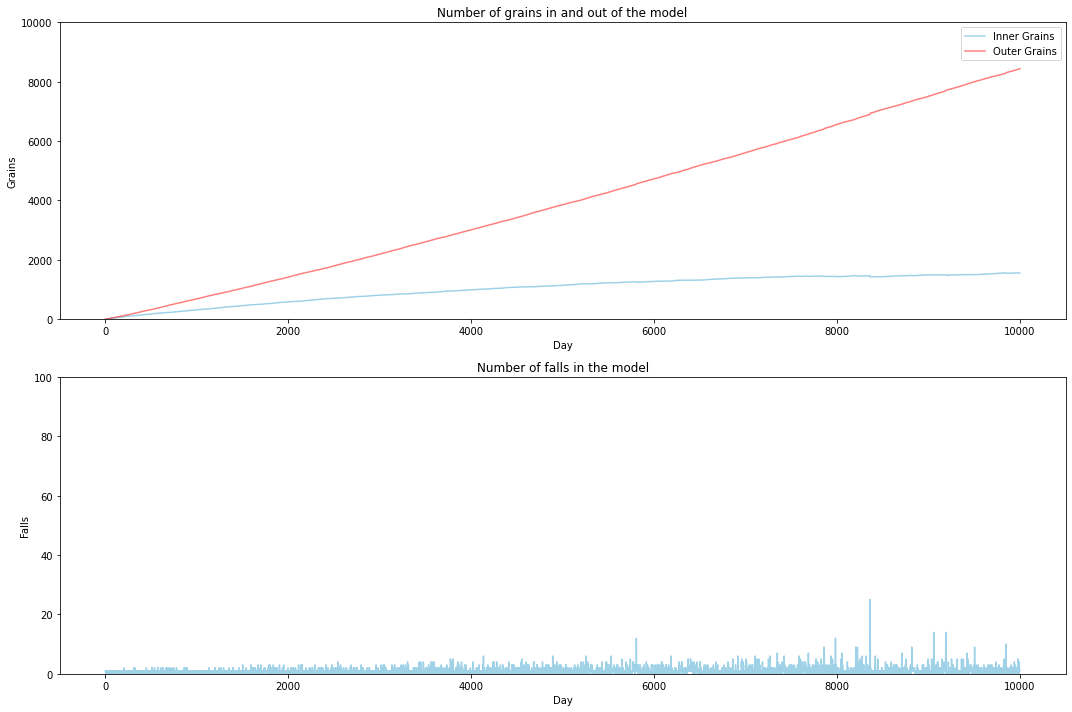

In [ ]:
covid_spread("FE", G_BA, number_of_days, new_grains, "BA")

100%|██████████| 9999/9999 [02:12<00:00, 75.25it/s]


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 97.0, 98.0, 98.0, 99.0, 100.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 132.0, 133.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 14

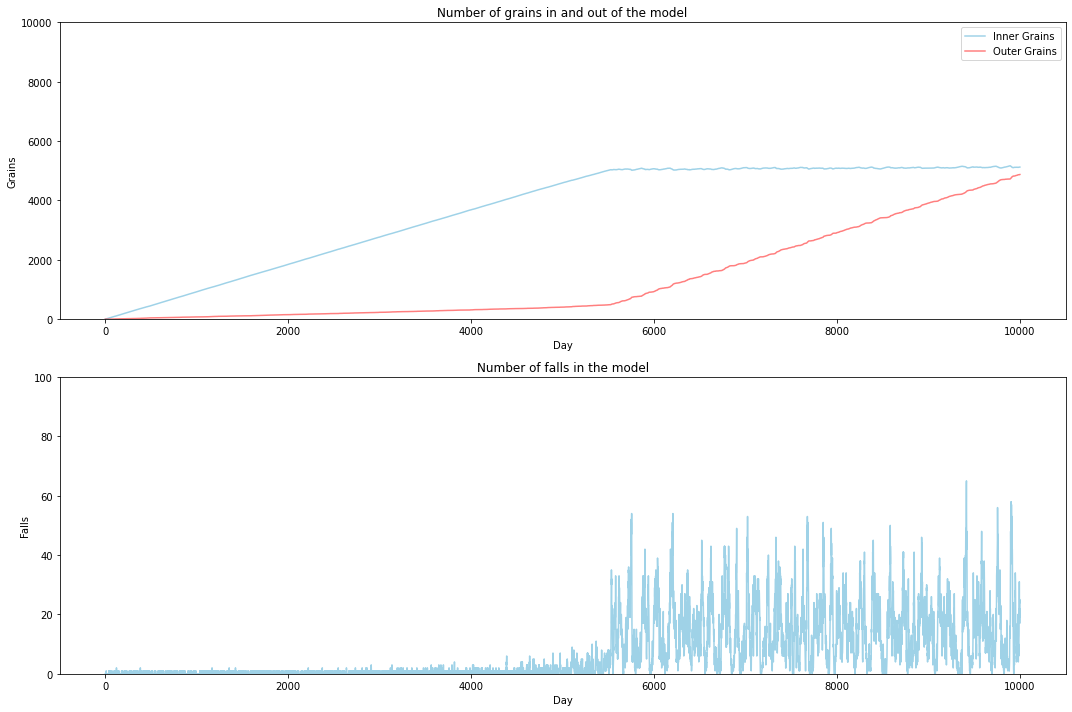

In [ ]:
covid_spread("FE", G_ER, number_of_days, new_grains, "ER")

#### Facilitated Model

100%|██████████| 9999/9999 [01:54<00:00, 87.41it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 37.0, 38.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 45.0, 45.0, 46.0, 46.0, 47.0, 47.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 53.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 55.0, 55.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 58.0, 58.0, 58.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 69.0, 69.0, 70.0, 70.0, 70.0, 70.0, 

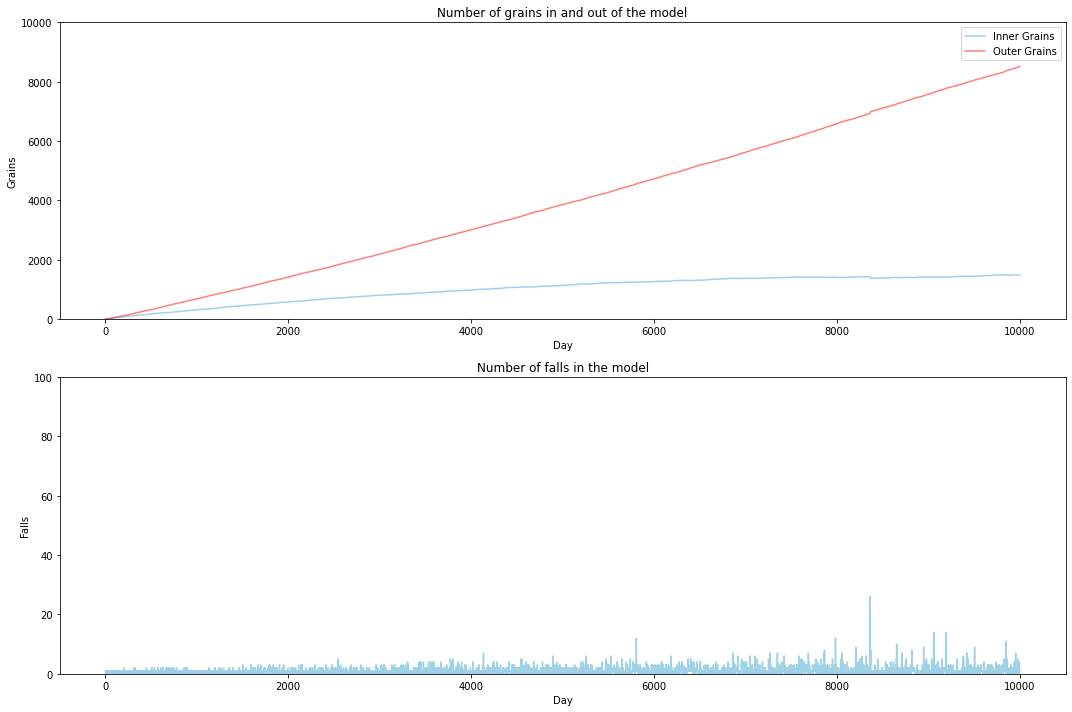

In [ ]:
covid_spread("FE", G_BA, number_of_days, new_grains, "BA", facilitated = True)

100%|██████████| 9999/9999 [02:11<00:00, 76.19it/s]


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 97.0, 98.0, 98.0, 99.0, 100.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 132.0, 133.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 14

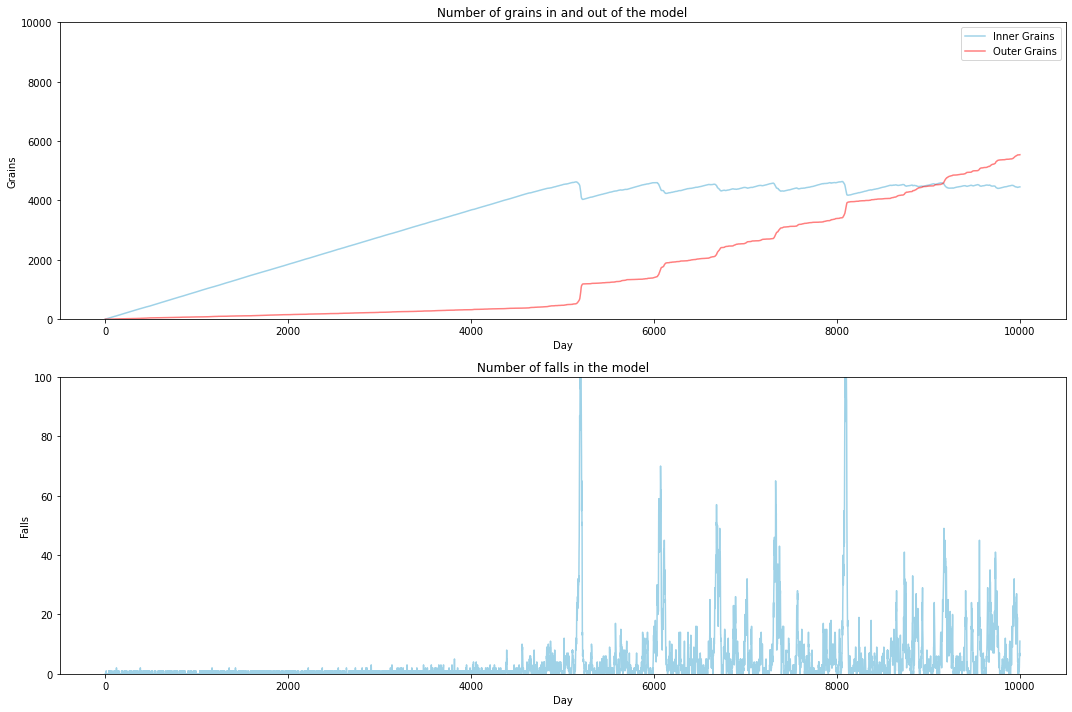

In [ ]:
covid_spread("FE", G_ER, number_of_days, new_grains, "ER", facilitated = True)

### Stochastic Feder

#### Standart Model

100%|██████████| 9999/9999 [01:49<00:00, 90.97it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 37.0, 38.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 45.0, 45.0, 46.0, 46.0, 47.0, 47.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 53.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 55.0, 55.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 58.0, 58.0, 58.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 69.0, 69.0, 70.0, 70.0, 70.0, 70.0, 

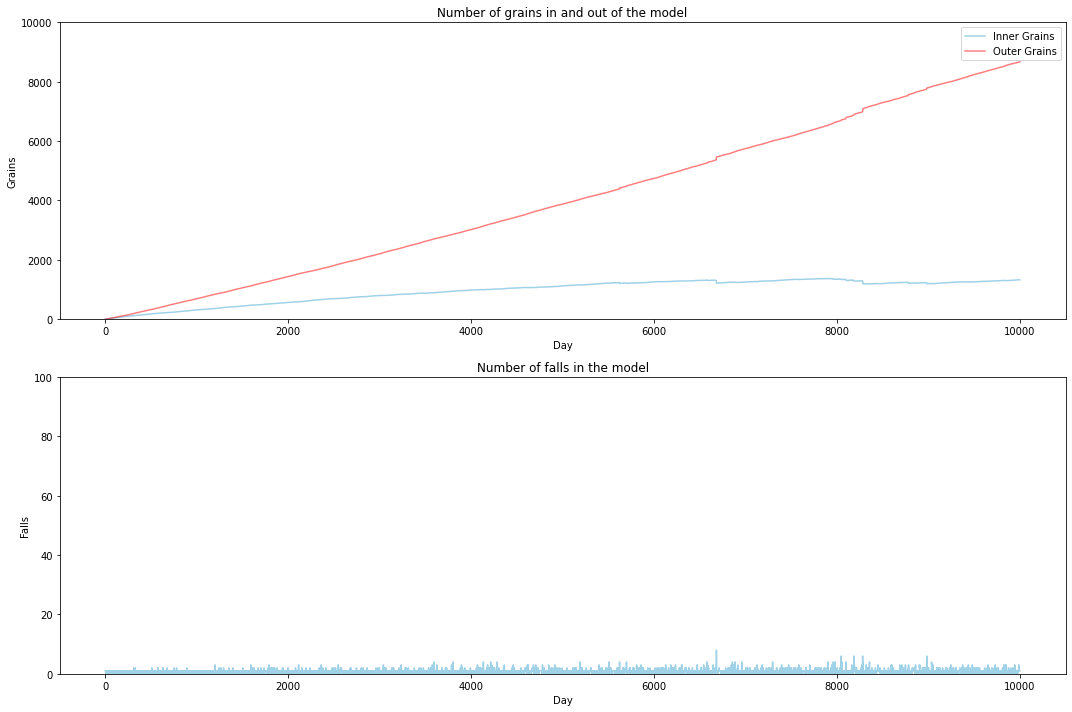

In [ ]:
covid_spread("SFE", G_BA, number_of_days, new_grains, "BA")

100%|██████████| 9999/9999 [01:47<00:00, 92.85it/s]


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 97.0, 98.0, 98.0, 99.0, 100.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 112.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 130.0, 131.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 14

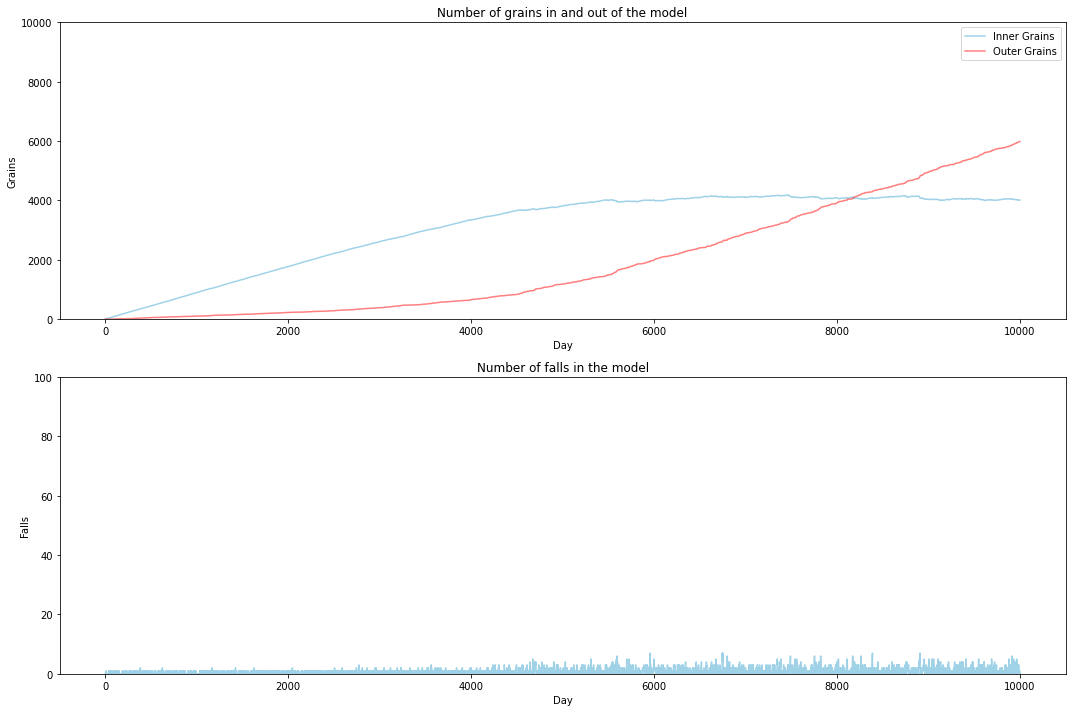

In [ ]:
covid_spread("SFE", G_ER, number_of_days, new_grains, "ER")

#### Facilitated Model

100%|██████████| 9999/9999 [01:59<00:00, 83.42it/s]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 19.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 28.0, 29.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0, 37.0, 38.0, 39.0, 40.0, 41.0, 41.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 45.0, 45.0, 46.0, 46.0, 47.0, 47.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 52.0, 53.0, 53.0, 53.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 55.0, 55.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 57.0, 58.0, 58.0, 58.0, 58.0, 59.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 61.0, 62.0, 63.0, 63.0, 64.0, 64.0, 65.0, 65.0, 66.0, 66.0, 67.0, 67.0, 68.0, 69.0, 69.0, 70.0, 70.0, 70.0, 70.0, 

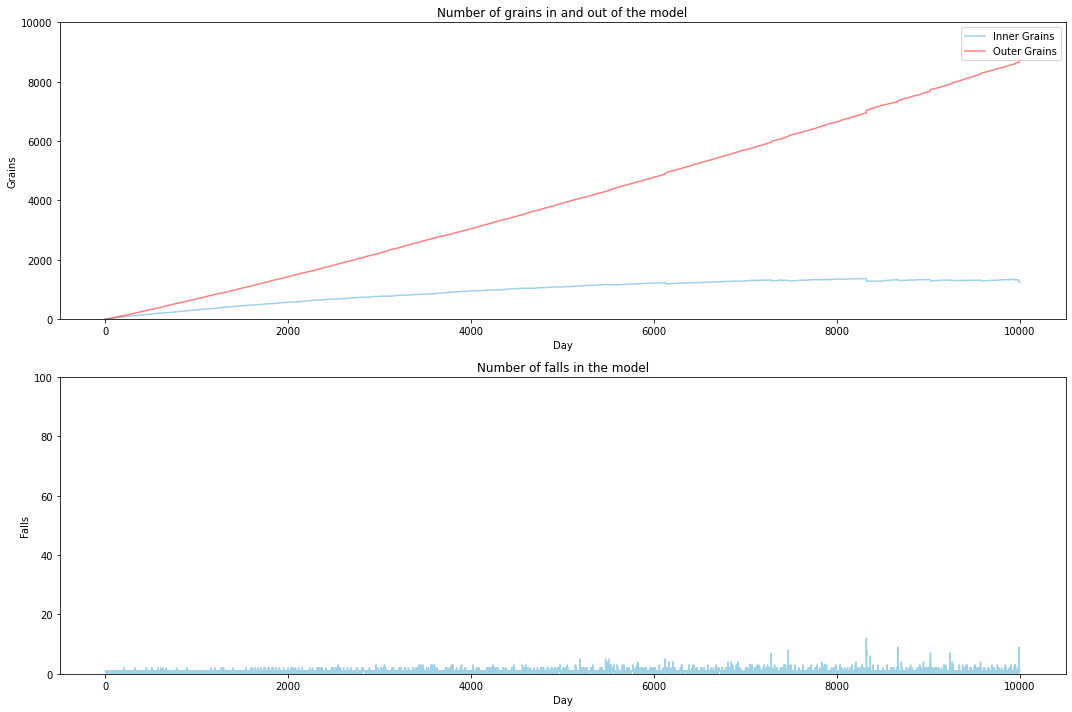

In [ ]:
covid_spread("SFE", G_BA, number_of_days, new_grains, "BA", facilitated = True)

100%|██████████| 9999/9999 [01:45<00:00, 94.75it/s]


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 50.0, 51.0, 52.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 96.0, 97.0, 97.0, 98.0, 99.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 112.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 130.0, 131.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.

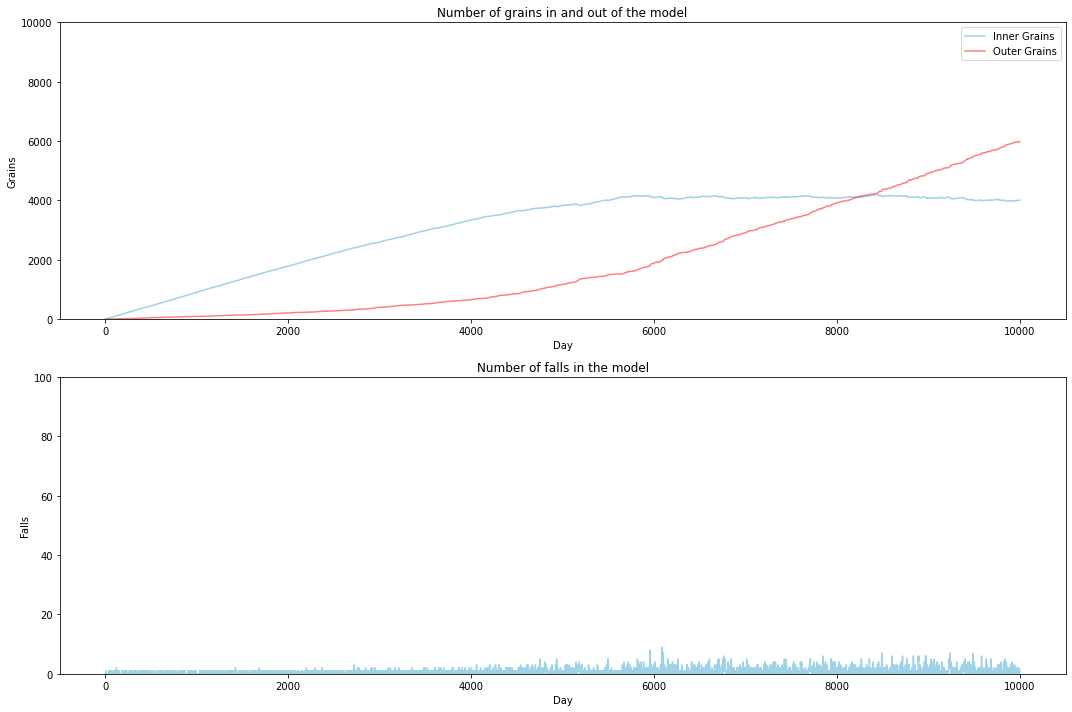

In [ ]:
covid_spread("SFE", G_ER, number_of_days, new_grains, "ER", facilitated = True)

### Graph statistics

#### Plotting function

In [ ]:
# Plotting

def k_distrib(graph, graph_type = None, scale='lin', colour='#40a6d1', alpha=.8, fit_line=False, expct_lo=1, expct_hi=10, expct_const=1):
    
    plt.close()
    num_nodes = graph.number_of_nodes()
    max_degree = 0
    
    # Calculate the maximum degree to know the range of x-axis
    for n in graph.nodes():
        if graph.degree(n) > max_degree:
            max_degree = graph.degree(n)
    
    # X-axis and y-axis values
    x = []
    y_tmp = []
    
    # Loop over all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree + 1):
        x.append(i)
        y_tmp.append(0)
        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp]
    
    if graph_type != None:  
      with open('/content/drive/MyDrive/MMCC/Graph_SOC/degrees_' + graph_type + '.csv', 'w') as myfile:
        wr = csv.writer(myfile, delimiter=',')
        wr.writerow(y_tmp)
    
    # Check for the lin / log parameter and set axes scale
    if scale == 'log':
        plt.figure(figsize=(10, 8))
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Degree distribution (log-log scale)')
        plt.ylabel('log(P(k))')
        plt.xlabel('log(k)')
        plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
        
        if fit_line:
            # Add theoretical distribution line k^-3
            # Note that you need to parametrize it manually
            w = [a for a in range(expct_lo,expct_hi)]
            z = []
            for i in w:
                x = (i**-3) * expct_const # set line's length and fit intercept
                z.append(x)

            plt.plot(w, z, 'k-', color='#7f7f7f')
            
    else:
        plt.figure(figsize=(10, 8))
        plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
        plt.title('Degree distribution (linear scale)')
        plt.ylabel('P(k)')
        plt.xlabel('k')

    plt.show()

#### Barabasi-Albert

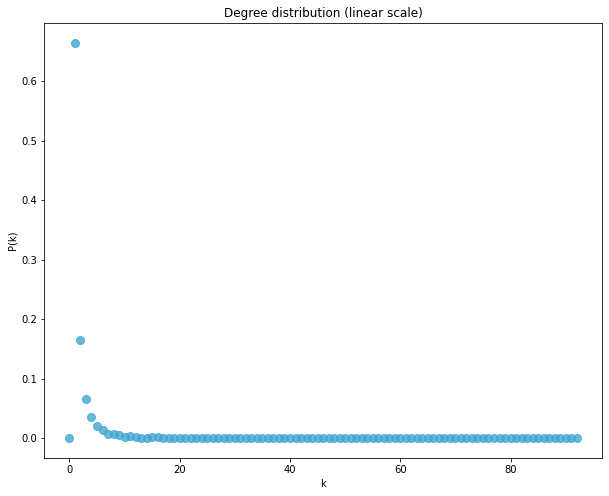

In [ ]:
k_distrib(G_BA, "BA")

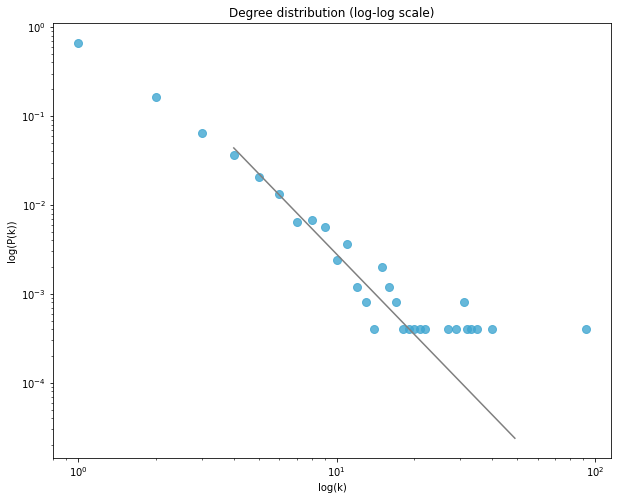

In [ ]:
k_distrib(G_BA, scale = 'log', fit_line = True, expct_lo=4, expct_hi=50, expct_const=2.8)

#### Erdos-Renyi

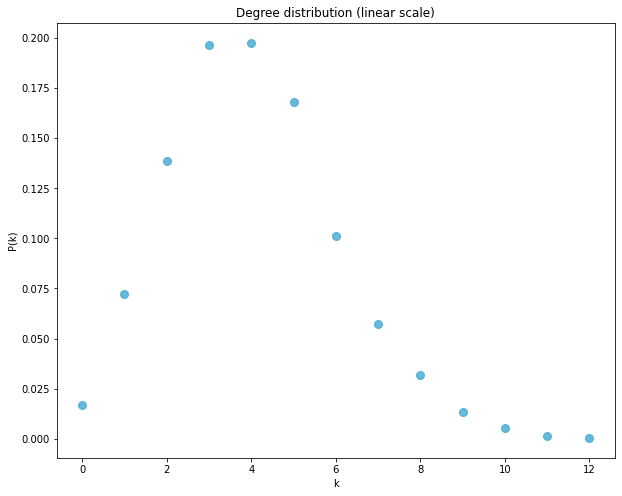

In [ ]:
k_distrib(G_ER, "ER")

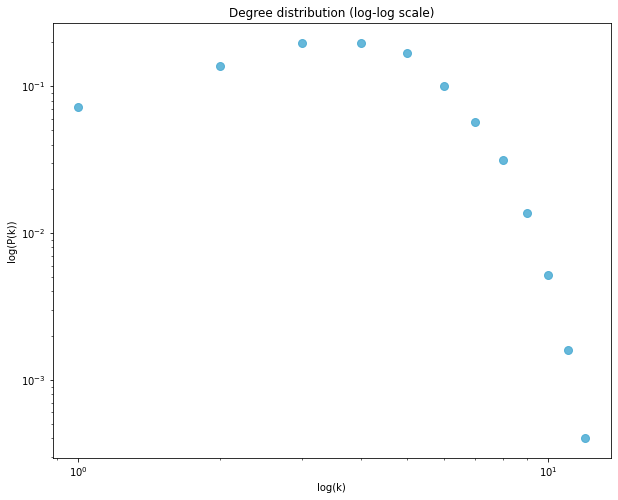

In [ ]:
k_distrib(G_ER, scale = 'log', fit_line = False, expct_lo=4, expct_hi=50, expct_const=2.8)